In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import model
import os
import sys
import time
import datetime
import dataloader
import os
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Compose
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch
import torch.nn as  nn
import torch.nn.functional as F
import torch
import  torchvision

/tmp/ipykernel_1655549/3188018843.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import model
from model import ResNet50
from dataloader import MILDataset
import torch
from sklearn.model_selection import train_test_split

In [3]:
train_data=pd.read_csv('trainset/trainset_true.csv')
train_df, test_df = train_test_split(train_data,
                                             test_size=0.3,
                                             random_state=999,
                                             shuffle=True,
                                             stratify=train_data.LABEL)

In [4]:
train_df.LABEL.value_counts()

LABEL
1    79
0    35
Name: count, dtype: int64

In [5]:
79/114

0.6929824561403509

In [6]:
train_dataset = MILDataset(root_dir='trainset/',
                         df=train_df,
                         transform=Compose([ToTensor()]))


val_dataset = MILDataset(root_dir='trainset/',
                         df=test_df,
                         transform=Compose([ToTensor()]))


train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [7]:
import torch.nn as nn
import torch

from torch import Tensor
from typing import Type

class BasicBlock(nn.Module):
    """Basic Block for ResNet18 and ResNet34"""
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None
    ) -> None:
        super(BasicBlock, self).__init__()
        # Multiplicative factor for the subsequent conv2d layer's output channels.
        # It is 1 for ResNet18 and ResNet34.
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels*self.expansion,
            kernel_size=3,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)
    def forward(self, x: Tensor) -> Tensor:
        identity = x # store copy of input tensor
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity # add input tensor to output tensor - residual connection
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(
        self,
        img_channels: int, # either grayscale or RGB images
        num_layers: int,K: int,
        block: Type[BasicBlock],
        num_classes: int = 1000, average='mean'
    ) -> None:
        super(ResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock`
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [1, 1, 1, 1]
            self.expansion = 1
        self.in_channels = K
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        self.average=average
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, K, layers[0])
        self.layer2 = self._make_layer(block, K*2, layers[1], stride=2)
        self.layer3 = self._make_layer(block, K*4, layers[2], stride=2)
        self.layer4 = self._make_layer(block, K*8, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(7*7*8*K*self.expansion, num_classes)
    def _make_layer(
        self,
        block: Type[BasicBlock],
        out_channels: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or 
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = [] # for storing the layers
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # The spatial dimension of the final layer's feature
        # map should be (7, 7) for all ResNets.
        # print('Dimensions of the last convolutional feature map: ', x.shape)
        #x = self.avgpool(x)
        
        x = torch.flatten(x, 1)
        #print(x.shape)
        if self.average=='mean':
            x = torch.mean(x, dim=0)
        return x

def CNN_net(K,average, num_classes=2):
    def __init__(self, K, num_classes=2, channels=3):
        super(CNN_net, self).__init__()
        self.ResNet=ResNet(img_channels=channels, num_layers=18, K=K, block=BasicBlock, num_classes=num_classes, average=average)
        self.fc = nn.Linear(K*8*7*7, num_classes)    
            
    def forward(self, bag_images):
       x = self.ResNet(bag_images)
       #print(x.shape, 'sortie res net')
       x = torch.mean(x, dim=0)
       #print(x.shape, 'sortie  mean')
       #x = F.relu(x)
       
       x = self.fc(x)
       print(x.shape, 'sortie  linear')
       #print(x.shape)
       #x = F.relu(x)
       x = torch.log_softmax(x,dim=0)
       #print(x.shape, 'sortie  softmax')
       #print(x)
       return x 

In [8]:
class CNN_net(nn.Module):
    def __init__(self, K, num_classes=2, channels=3, average='mean'):
        super(CNN_net, self).__init__()
        # Supposons que ResNet et BasicBlock sont définis ailleurs correctement.
        self.ResNet = ResNet(img_channels=channels, num_layers=18, K=K, block=BasicBlock, num_classes=num_classes, average=average)
        self.fc = nn.Linear(K*8*7*7, num_classes)

    def forward(self, bag_images):
        x = self.ResNet(bag_images)
        #print(x.shape, 'sortie mean')
        x = self.fc(x)
        #print(x.shape, 'sortie linear')
        x = torch.log_softmax(x, dim=0)
        #print(x.shape, 'sortie softmax')
        return x

In [23]:
ResNet18=ResNet(3, 18, 64, BasicBlock, 2, 'mean').to('cuda')
device='cuda'
#p.train()
for i, data in (enumerate(train_loader)):
    inputs, labels = data
    images=inputs['instances'].squeeze(0).to(device)
    print(final_model(images).shape)


torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])


torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Si

In [24]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight)



In [12]:
batch_size=30
epochs=1000
list_train_loss=[]
list_val_loss=[]
print_frequency = 10
save_frequency = 10
save_model = True
final_model=CNN_net(K=32, average='mean', num_classes=2).to('cuda')
final_model.apply(init_weights)
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.000006, betas=(0.9, 0.999), weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10, verbose=True)

loss_fn = nn.NLLLoss()
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    
    print('******** Epoch [{}/{}]  ********'.format(epoch+1, epochs))
    final_model.train()
    print('Training')
    train_loss=0
    accumulated_inputs=[]
    accumulated_labels=[]
    len_current_batch=0
    for i, data in (enumerate(train_loader)):
        
        
        len_current_batch+=1
        inputs, labels = data
        #print(inputs['id'])
        images=inputs['instances'][0].cuda()
        labels=labels.cuda()
        accumulated_inputs.append(images)
        accumulated_labels.append(labels)
        if len_current_batch==batch_size or i==len(train_loader)-1:
            optimizer.zero_grad()
            loss=0
            for j in range(len_current_batch):
                outputs = final_model(accumulated_inputs[j].to('cuda'))
                _, preds = torch.max(outputs.unsqueeze(0), 1)
                u=loss_fn(outputs.unsqueeze(0), accumulated_labels[j])
                #print(torch.exp(outputs),u,accumulated_labels[j])
                if preds==0:
                    loss+=loss_fn(outputs.unsqueeze(0), accumulated_labels[j])
                else:
                    loss+=loss_fn(outputs.unsqueeze(0), accumulated_labels[j])
            train_loss+=loss.item()
            loss.backward()
            optimizer.step()
            accumulated_inputs=[]
            accumulated_labels=[]
            
            len_current_batch=0
            #print('end of one batch')
    list_train_loss.append(train_loss/len(train_loader))
    print('Validation')
    val_loss=0
    with torch.no_grad():   # Disable gradient computation (faster and saves memory)
        final_model.eval()        # Disable Dropout and BatchNormalization
        all_preds = []
        all_labels = []
        for k, data in enumerate(val_loader):
            inputs, labels = data
            images=inputs['instances'][0].cuda()
            outputs=final_model(images).cuda()
            labels=labels.cuda()
            loss=loss_fn(outputs.unsqueeze(0), labels)
            _, preds = torch.max(outputs.unsqueeze(0), 1)  # Get the index of the max log-probability as the prediction
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            if preds==0:
                val_loss+=loss.item()
            else:
                val_loss+=loss.item()
        list_val_loss.append(val_loss/len(val_loader))
        #scheduler.step(val_loss/len(val_loader))
        balanced_acc = balanced_accuracy_score(all_labels, all_preds)
        accuracy = accuracy_score(all_labels, all_preds)
        
        # Calcul de la matrice de confusion
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        
        # Calcul du taux de vrais positifs (sensibilité) et de faux négatifs
        sensitivity = tp / (tp + fn)
        false_negative_rate = fn / (fn + tp)
        
        # Calcul de l'accuracy équilibrée
        balanced_acc = balanced_accuracy_score(all_labels, all_preds)
        
        #list_val_loss.append(val_loss)
    
    # Journalisation
        print('Epoch [{}/{}] train_loss: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}, val_sensitivity: {:.4f}, val_FNR: {:.4f}, val_balanced_acc: {:.4f}'.format(
        epoch+1, epochs, train_loss/len(train_loader), val_loss/len(val_loader), accuracy, sensitivity, false_negative_rate, balanced_acc))

plt.plot(list_train_loss, label='train_loss')
plt.plot(list_val_loss, label='val_loss')


/users/eleves-b/2020/damien.vilcocq/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/1000 [00:00<?, ?it/s]

******** Epoch [1/1000]  ********
Training


Validation


  0%|          | 1/1000 [00:07<2:08:52,  7.74s/it]

Epoch [1/1000] train_loss: 0.7616, val_loss: 0.6730, val_accuracy: 0.6735, val_sensitivity: 0.9412, val_FNR: 0.0588, val_balanced_acc: 0.5039
******** Epoch [2/1000]  ********
Training
Validation


  0%|          | 2/1000 [00:15<2:07:39,  7.67s/it]

Epoch [2/1000] train_loss: 0.6567, val_loss: 0.6201, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [3/1000]  ********
Training
Validation


  0%|          | 3/1000 [00:23<2:08:23,  7.73s/it]

Epoch [3/1000] train_loss: 0.6235, val_loss: 0.6164, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [4/1000]  ********
Training
Validation


  0%|          | 4/1000 [00:30<2:08:59,  7.77s/it]

Epoch [4/1000] train_loss: 0.6229, val_loss: 0.6230, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [5/1000]  ********
Training
Validation


  0%|          | 5/1000 [00:38<2:09:09,  7.79s/it]

Epoch [5/1000] train_loss: 0.6235, val_loss: 0.6220, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [6/1000]  ********
Training
Validation


  1%|          | 6/1000 [00:46<2:09:53,  7.84s/it]

Epoch [6/1000] train_loss: 0.6162, val_loss: 0.6147, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [7/1000]  ********
Training
Validation


  1%|          | 7/1000 [00:54<2:09:36,  7.83s/it]

Epoch [7/1000] train_loss: 0.6057, val_loss: 0.6078, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [8/1000]  ********
Training
Validation


  1%|          | 8/1000 [01:02<2:09:28,  7.83s/it]

Epoch [8/1000] train_loss: 0.5980, val_loss: 0.6047, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [9/1000]  ********
Training
Validation


  1%|          | 9/1000 [01:10<2:09:24,  7.83s/it]

Epoch [9/1000] train_loss: 0.5945, val_loss: 0.6039, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [10/1000]  ********
Training
Validation


  1%|          | 10/1000 [01:17<2:08:30,  7.79s/it]

Epoch [10/1000] train_loss: 0.5927, val_loss: 0.6027, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [11/1000]  ********
Training
Validation


  1%|          | 11/1000 [01:25<2:08:19,  7.79s/it]

Epoch [11/1000] train_loss: 0.5900, val_loss: 0.6002, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [12/1000]  ********
Training
Validation


  1%|          | 12/1000 [01:33<2:08:33,  7.81s/it]

Epoch [12/1000] train_loss: 0.5861, val_loss: 0.5976, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [13/1000]  ********
Training
Validation


  1%|▏         | 13/1000 [01:41<2:08:24,  7.81s/it]

Epoch [13/1000] train_loss: 0.5820, val_loss: 0.5956, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [14/1000]  ********
Training
Validation


  1%|▏         | 14/1000 [01:49<2:08:14,  7.80s/it]

Epoch [14/1000] train_loss: 0.5783, val_loss: 0.5941, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [15/1000]  ********
Training
Validation


  2%|▏         | 15/1000 [01:56<2:08:01,  7.80s/it]

Epoch [15/1000] train_loss: 0.5746, val_loss: 0.5925, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [16/1000]  ********
Training
Validation


  2%|▏         | 16/1000 [02:04<2:08:03,  7.81s/it]

Epoch [16/1000] train_loss: 0.5709, val_loss: 0.5909, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [17/1000]  ********
Training
Validation


  2%|▏         | 17/1000 [02:12<2:08:17,  7.83s/it]

Epoch [17/1000] train_loss: 0.5674, val_loss: 0.5892, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [18/1000]  ********
Training
Validation


  2%|▏         | 18/1000 [02:20<2:08:23,  7.84s/it]

Epoch [18/1000] train_loss: 0.5640, val_loss: 0.5877, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [19/1000]  ********
Training
Validation


  2%|▏         | 19/1000 [02:28<2:08:13,  7.84s/it]

Epoch [19/1000] train_loss: 0.5609, val_loss: 0.5862, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [20/1000]  ********
Training
Validation


  2%|▏         | 20/1000 [02:36<2:08:25,  7.86s/it]

Epoch [20/1000] train_loss: 0.5579, val_loss: 0.5848, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [21/1000]  ********
Training
Validation


  2%|▏         | 21/1000 [02:44<2:08:23,  7.87s/it]

Epoch [21/1000] train_loss: 0.5548, val_loss: 0.5834, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [22/1000]  ********
Training
Validation


  2%|▏         | 22/1000 [02:52<2:08:13,  7.87s/it]

Epoch [22/1000] train_loss: 0.5517, val_loss: 0.5821, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [23/1000]  ********
Training
Validation


  2%|▏         | 23/1000 [02:59<2:08:15,  7.88s/it]

Epoch [23/1000] train_loss: 0.5486, val_loss: 0.5808, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [24/1000]  ********
Training
Validation


  2%|▏         | 24/1000 [03:07<2:08:09,  7.88s/it]

Epoch [24/1000] train_loss: 0.5455, val_loss: 0.5795, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [25/1000]  ********
Training
Validation


  2%|▎         | 25/1000 [03:15<2:08:14,  7.89s/it]

Epoch [25/1000] train_loss: 0.5425, val_loss: 0.5783, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [26/1000]  ********
Training
Validation


  3%|▎         | 26/1000 [03:23<2:08:24,  7.91s/it]

Epoch [26/1000] train_loss: 0.5396, val_loss: 0.5772, val_accuracy: 0.6939, val_sensitivity: 1.0000, val_FNR: 0.0000, val_balanced_acc: 0.5000
******** Epoch [27/1000]  ********
Training


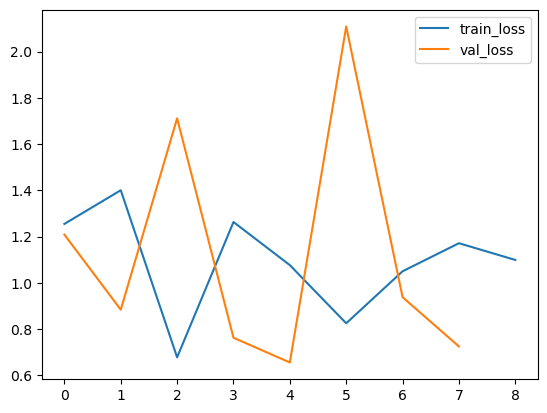

In [20]:
plt.plot(list_train_loss, label='train_loss')
plt.plot(list_val_loss, label='val_loss')
plt.legend()


In [ ]:
c=0
for i in all_labels:
    if i==0:
        c+=1
print(c/len(all_preds))

0.12244897959183673


In [ ]:
print(len(all_labels))

AttributeError: 'DataLoader' object has no attribute 'labels'

In [ ]:
torch.exp(outputs)

tensor([0.8801, 0.1199])

In [ ]:
torch.cat((torch.exp(outputs).unsqueeze(0), (1-torch.exp(outputs)).unsqueeze(0)),0)

tensor([[0.8801, 0.1199],
        [0.1199, 0.8801]])

In [ ]:
u=torch.cat((torch.exp(outputs).unsqueeze(0), (1-torch.exp(outputs)).unsqueeze(0)),0)
torch.argmax(u,1)

tensor([0, 1])

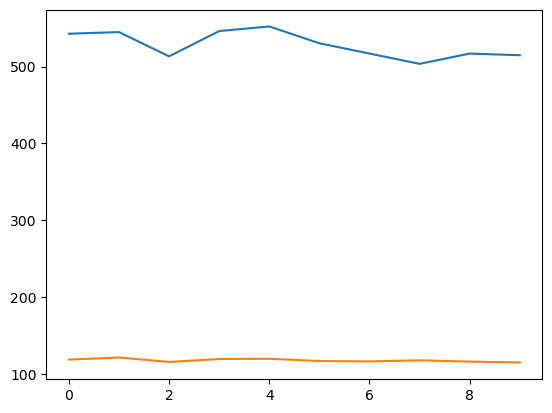

In [ ]:
plt.plot(list_train_loss, label='train_loss')
plt.plot(list_val_loss, label='val_loss')

In [ ]:
res.train()

CNN(
  (ResNet): ResNet(
    (conv1): Conv2d(3, 3, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (batch_norm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Block(
        (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batch_norm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batch_norm2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    )
    (layer2): Sequential(
      (0): Block(
        (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (batch_norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=

In [ ]:
print(outputs.shape)
print(labels.shape)

torch.Size([2])
torch.Size([1])


In [ ]:
outputs[0]

tensor(0.4137, grad_fn=<SelectBackward0>)

In [ ]:
accumulated_labels[0]

tensor([0])